In [2]:
from pathlib import Path
from datetime import datetime
import json
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from reproducible_figures import (
    save_reproducible_figure, set_plotting_style
)

In [2]:
# EXPERIMENT_FOLDER = "./experiments/subset_permutation/07-10_02-11"
EXPERIMENT_FOLDER = "./experiments/message_mutation_1/09-10_02-05"

NUM_CLASSES = 3
CHANNEL_SIZE = 5

In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.vary_play_param_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *


NUM_CLASSES = 3
CHANNEL_SIZE = 5
BATCH_SIZE = 32

TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)


def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def create_channel_subset_permutation_experiment(
    permutation_subset_size=3, **experiment_kwargs
):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': permutation_subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        lr=1e-2,
        name='channel_subset_permutation',
        **experiment_kwargs
    )



def create_self_play_experiment(p_mutate=0.3, **exp_kwargs):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    play_params =  {
        'channel_size': CHANNEL_SIZE, 
        'p_mutate': p_mutate,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        **exp_kwargs
    )

2024-04-23 12:11:07.410271: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 12:11:08.039692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 12:11:08.039731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 12:11:08.148078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 12:11:08.346249: I tensorflow/core/platform/cpu_feature_guar

In [14]:
# experiment = VaryPlayParamExperiment(
#     save_location=EXPERIMENT_FOLDER,
#     param_vals=[2, 3, 4, 5],
#     param_name='permutation_subset_size',
#     max_epochs=200,
#     num_experiments_per_val=3,
#     create_experiment_fn=create_channel_subset_permutation_experiment
# )


experiment = VaryPlayParamExperiment(save_location=EXPERIMENT_FOLDER,
                                     param_vals=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                     param_name='p_mutate',
                                     max_epochs=50,
                                     num_experiments_per_val=3,
                                     create_experiment_fn=create_self_play_experiment)

In [15]:
responsiveness_vals = []

for meta_idx, meta_exp_item in enumerate(experiment.experiments):
    meta_exp = meta_exp_item['experiment']
    for exp_idx, exp_item in enumerate(meta_exp.experiments):
        exp = exp_item['experiment']
        responsiveness_vals.append({
            'Student Responsiveness': exp.compute_student_responsiveness(),
            'Teacher Responsiveness': exp.compute_teacher_responsiveness(),
            'Meta Experiment Index': meta_idx,
            'Experiment Index': exp_idx,
            **exp.get_play_params()
        })

responsiveness_df = pd.DataFrame(responsiveness_vals)

In [16]:
X_NAME = 'Mutation Probability'

def get_experiment_item(experiment_path):
    with open(experiment_path / 'results.json', 'r') as f:
        results = json.load(f)
    with open(experiment_path / 'meta.json', 'r') as f:
        config = json.load(f)
    p_mutate = config['experiment_config']['play_params']['p_mutate']

    return [
        {
            X_NAME: p_mutate,
            'Zero-Shot Coordination Score': sub_item['mean_ground_truth_f1'],
            'Protocol Diversity': sub_item['mean_protocol_diversity'],
            **sub_item
        }
        for item in results
        for sub_item in item['vanilla_params_test_metrics']
    ]

zs_coord_df = pd.DataFrame([
    item
    for experiment_path in Path(EXPERIMENT_FOLDER).glob('*')
    for item in get_experiment_item(experiment_path)
])

In [17]:
# responsiveness_df[X_NAME] = responsiveness_df['permutation_subset_size']
responsiveness_df[X_NAME] = responsiveness_df['p_mutate']

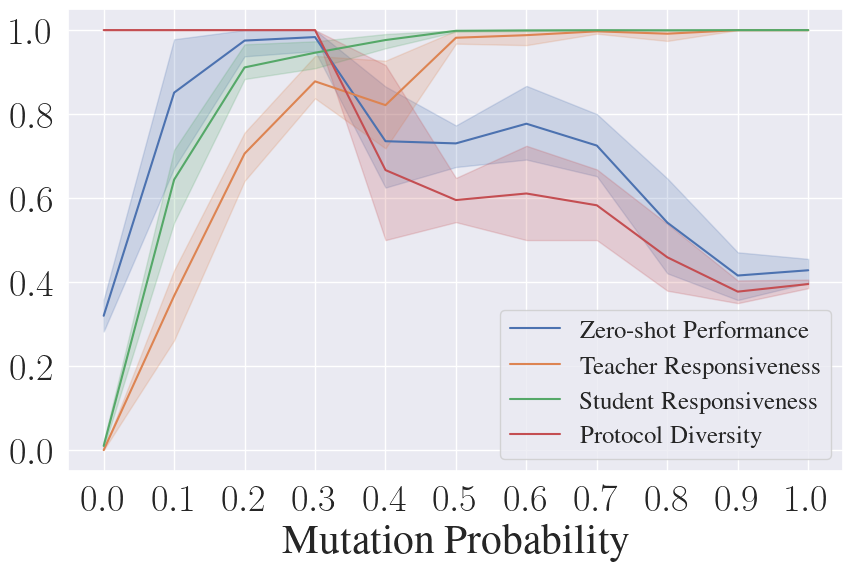

reformatted figures/msg_mutation_experiments_metrics/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [20]:
def plot_metrics_with_p_mutate(zs_coord_df, responsiveness_df):
    # set_plotting_style()
    set_plotting_style(font_scale=2.5, rc={"legend.fontsize": 18})

    # plt.figure(figsize=(8, 4))
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                data=zs_coord_df, label='Zero-shot Performance')
    sns.lineplot(x=X_NAME, y='Teacher Responsiveness', 
                data=responsiveness_df, label='Teacher Responsiveness')
    sns.lineplot(x=X_NAME, y='Student Responsiveness', 
                data=responsiveness_df, label='Student Responsiveness')
    sns.lineplot(x=X_NAME, y='Protocol Diversity', 
                data=zs_coord_df, label='Protocol Diversity')

    plt.ylim([-0.05, 1.05])

    # plt.xlim([1.95, CHANNEL_SIZE + .05])
    # plt.title('The Effect of Channel Permutation on Zero-Shot Coordination')
    plt.ylabel('')
    plt.xlabel('Mutation Probability')
    plt.xticks(pd.unique(zs_coord_df[X_NAME]))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc=4)
# plt.show()


save_reproducible_figure(
    'msg_mutation_experiments_metrics',
    (zs_coord_df, responsiveness_df),
    plot_metrics_with_p_mutate,
    show=True
)

In [57]:
# EXPERIMENT_FOLDER = "./experiments/subset_permutation/07-10_02-11"
EXPERIMENT_FOLDER = "./experiments/message_mutation_1/09-10_02-05"

NUM_CLASSES = 3
CHANNEL_SIZE = 5

# experiment = VaryPlayParamExperiment(
#     save_location=EXPERIMENT_FOLDER,
#     param_vals=[2, 3, 4, 5],
#     param_name='permutation_subset_size',
#     max_epochs=200,
#     num_experiments_per_val=3,
#     create_experiment_fn=create_channel_subset_permutation_experiment
# )


experiment = VaryPlayParamExperiment(save_location=EXPERIMENT_FOLDER,
                                     param_vals=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                     param_name='p_mutate',
                                     max_epochs=50,
                                     num_experiments_per_val=3,
                                     create_experiment_fn=create_self_play_experiment)


In [78]:
history_items = []

# meta_exp = experiment.experiments[0]['experiment']
# exp = meta_exp.experiments[0]['experiment']
# history_item = exp.training_history[0]

for meta_idx, meta_exp_item in enumerate(experiment.experiments):
    meta_exp = meta_exp_item['experiment']
    for exp_idx, exp_item in enumerate(meta_exp.experiments):
        exp = exp_item['experiment']
        if len(exp.training_history) < 50:
            continue
        for history_item in exp.training_history:
            history_items.append({
                'epoch': 1 + history_item['experiment_state']['epochs_optimised'],
                'loss': history_item['loss'],
                **history_item['experiment_state']['play_params'],
                **history_item.get('test_metrics', {}),
                r'$p_{m}$': meta_exp_item['p_mutate'],
                'Meta Experiment Index': meta_idx,
                'Experiment Index': exp_idx,
            })

history_df = pd.DataFrame(history_items)

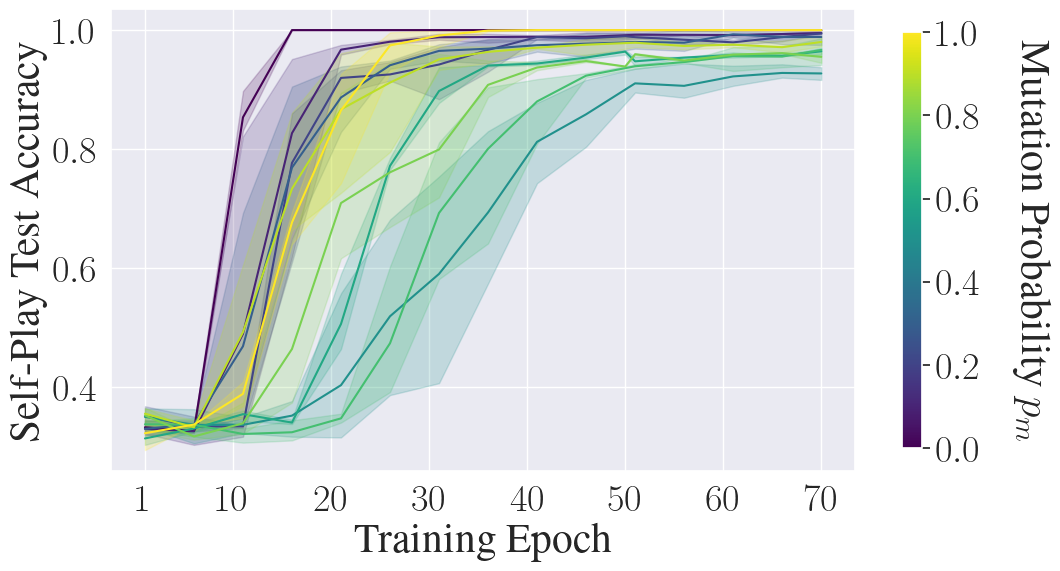

reformatted figures/message_mutation_experiment_training_curves/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [84]:
from seaborn.palettes import color_palette

def plot_message_mutation_experiment_training_curves(history_df):
    set_plotting_style(font_scale=2.5)

    plt.figure(figsize=(12, 6))

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

    ax = sns.lineplot(history_df,
                      x='epoch',
                      y='ground_truth_acc',
                      hue=r'$p_{m}$',
                      palette='viridis',
                      legend=False)

    # ax.get_legend().remove()
    cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.9)
    cbar.set_label(
        r'Mutation Probability $p_{m}$',
        rotation=-90, 
        labelpad=50.0,
    )

    ax.set_xticks([1]+list(range(10, 71, 10)))

    plt.xlabel('Training Epoch')
    plt.ylabel('Self-Play Test Accuracy')


save_reproducible_figure(
    'message_mutation_experiment_training_curves',
    history_df,
    plot_message_mutation_experiment_training_curves,
    show=True
)

In [4]:
EXPERIMENT_FOLDER = "./experiments/subset_permutation/07-10_02-11"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/09-10_02-05"

NUM_CLASSES = 3
CHANNEL_SIZE = 5

experiment = VaryPlayParamExperiment(
    save_location=EXPERIMENT_FOLDER,
    param_vals=[2, 3, 4, 5],
    param_name='permutation_subset_size',
    max_epochs=200,
    num_experiments_per_val=3,
    create_experiment_fn=create_channel_subset_permutation_experiment
)


# experiment = VaryPlayParamExperiment(save_location=EXPERIMENT_FOLDER,
#                                      param_vals=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                                      param_name='p_mutate',
#                                      max_epochs=50,
#                                      num_experiments_per_val=3,
#                                      create_experiment_fn=create_self_play_experiment)


2024-04-23 12:11:14.787417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 12:11:15.188097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 12:11:15.188148: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 12:11:15.193934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 12:11:15.194003: I external/local_xla/xla/stream_executor

In [44]:
history_items = []

# meta_exp = experiment.experiments[0]['experiment']
# exp = meta_exp.experiments[0]['experiment']
# history_item = exp.training_history[0]

for meta_idx, meta_exp_item in enumerate(experiment.experiments):
    meta_exp = meta_exp_item['experiment']
    for exp_idx, exp_item in enumerate(meta_exp.experiments):
        exp = exp_item['experiment']
        for history_item in exp.training_history:
            history_items.append({
                'epoch': history_item['experiment_state']['epochs_optimised'],
                'loss': history_item['loss'],
                **history_item['experiment_state']['play_params'],
                **history_item.get('test_metrics', {}),
                'Subset Size': meta_exp_item['permutation_subset_size'],
                'Meta Experiment Index': meta_idx,
                'Experiment Index': exp_idx,
            })

history_df = pd.DataFrame(history_items)

In [45]:
history_df.head()

,epoch,loss,channel_size,p_mutate,message_permutation,permutation_subset_size,channel_temp,mean_test_loss,mean_ground_truth_f1,ground_truth_acc,mean_student_error,mean_teacher_error,mean_protocol_diversity,mean_protocol_entropy,Subset Size,Meta Experiment Index,Experiment Index
0,0,1.100999,5,0,True,2.0,10.000000,1.100017,0.3125,0.3125,1.104667,1.516194,0.387708,1.130454,2,0,0
1,1,1.074314,5,0,True,2.0,9.772372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0
2,2,0.531993,5,0,True,2.0,9.549926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0
3,3,0.806002,5,0,True,2.0,9.332543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0
4,4,0.024786,5,0,True,2.0,9.120108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0


/tmp/ipykernel_692/325894013.py:8: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(history_df,


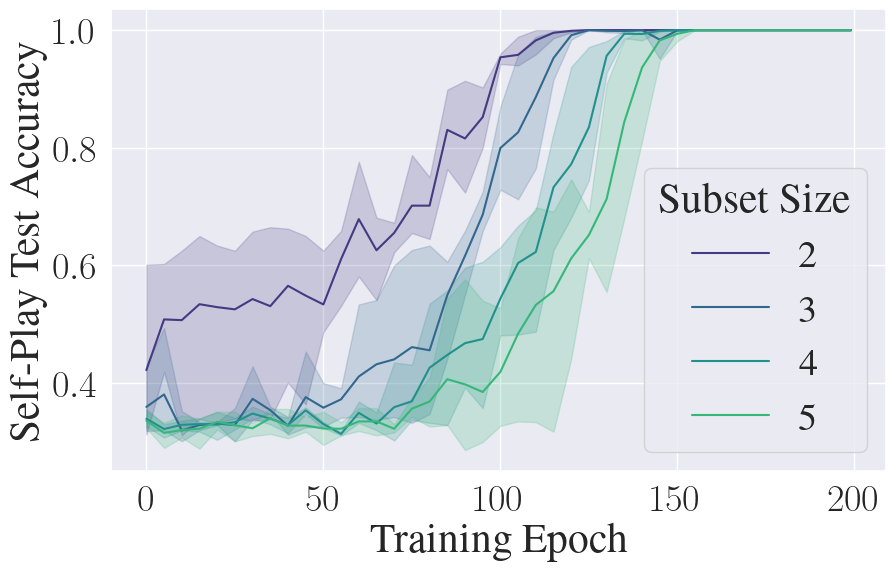

reformatted figures/subset_permutation_experiment_training_curves/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [54]:
from seaborn.palettes import color_palette

def plot_subset_permutation_experiment_training_curves(history_df):
    set_plotting_style(font_scale=2.5)

    plt.figure(figsize=(10, 6))

    sns.lineplot(history_df,
                 x='epoch',
                 y='ground_truth_acc',
                 hue='Subset Size',
                 palette=color_palette('viridis', 5))
    
    plt.xlabel('Training Epoch')
    plt.ylabel('Self-Play Test Accuracy')


save_reproducible_figure(
    'subset_permutation_experiment_training_curves',
    history_df,
    plot_subset_permutation_experiment_training_curves,
    show=True
)

In [ ]:
X_NAME = 'Permuted Proportion'


def get_experiment_item(experiment_path):
    with open(experiment_path / 'results.json', 'r') as f:
        results = json.load(f)
    with open(experiment_path / 'meta.json', 'r') as f:
        config = json.load(f)
    permutation_subset_size = config['experiment_config']['play_params']['permutation_subset_size']

    return [
        {
            X_NAME: permutation_subset_size,
            'Zero-Shot Coordination Score': sub_item['mean_ground_truth_f1'],
            'Protocol Diversity': sub_item['mean_protocol_diversity'],
            **sub_item
        }
        for item in results
        for sub_item in item['vanilla_params_test_metrics']
    ]

zs_coord_df = pd.DataFrame([
    item
    for experiment_path in Path(EXPERIMENT_FOLDER).glob('*')
    for item in get_experiment_item(experiment_path)
])
zs_coord_df.head()

In [ ]:
responsiveness_vals = []

for meta_idx, meta_exp_item in enumerate(experiment.experiments):
    meta_exp = meta_exp_item['experiment']
    for exp_idx, exp_item in enumerate(meta_exp.experiments):
        exp = exp_item['experiment']
        responsiveness_vals.append({
            'Student Responsiveness': exp.compute_student_responsiveness(),
            'Teacher Responsiveness': exp.compute_teacher_responsiveness(),
            'Meta Experiment Index': meta_idx,
            'Experiment Index': exp_idx,
            **exp.get_play_params()
        })

responsiveness_df = pd.DataFrame(responsiveness_vals)
responsiveness_df[X_NAME] = responsiveness_df['permutation_subset_size']

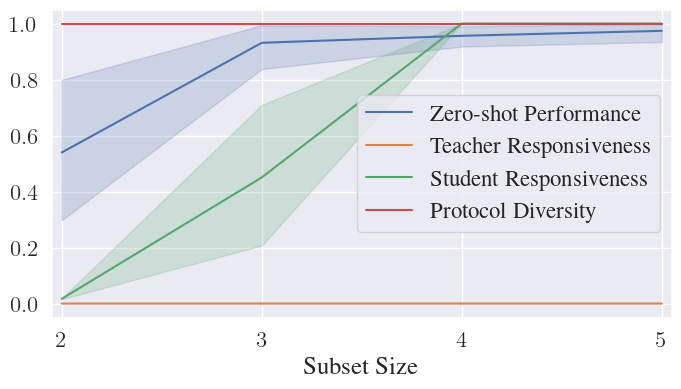

reformatted figures/subset_permutation_experiments_metrics/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [35]:
def plot_metrics_with_subset_size(zs_coord_df, responsiveness_df):
    set_plotting_style()

    plt.figure(figsize=(8, 4))

    sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                data=zs_coord_df, label='Zero-shot Performance')
    sns.lineplot(x=X_NAME, y='Teacher Responsiveness', 
                data=responsiveness_df, label='Teacher Responsiveness')
    sns.lineplot(x=X_NAME, y='Student Responsiveness', 
                data=responsiveness_df, label='Student Responsiveness')
    sns.lineplot(x=X_NAME, y='Protocol Diversity', 
                data=zs_coord_df, label='Protocol Diversity')

    plt.ylim([-0.05, 1.05])

    plt.xlim([1.95, CHANNEL_SIZE + .05])
    # plt.title('The Effect of Channel Permutation on Zero-Shot Coordination')
    plt.ylabel('')
    plt.xlabel('Subset Size')
    plt.xticks(pd.unique(zs_coord_df[X_NAME]))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc=4)
# plt.show()


save_reproducible_figure(
    'subset_permutation_experiments_metrics',
    (zs_coord_df, responsiveness_df),
    plot_metrics_with_subset_size,
    show=True
)